<a href="https://colab.research.google.com/github/Swethagovind05/ASSIGNMENT002/blob/main/Swetha_Hip_implant_loosening_detection_Hybrid_Model_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import os
import zipfile
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
import kaggle
print("Imported kaggle API successfully !")

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Imported kaggle API successfully !


In [ ]:
print("Downloading dataset : ")
!kaggle datasets download vuppalaadithyasairam/hip-implant-loose-detection-from-radiographs
print("Downloaded Successfully!")

Dataset URL: https://www.kaggle.com/datasets/vuppalaadithyasairam/hip-implant-loose-detection-from-radiographs
License(s): CC-BY-NC-SA-4.0
hip-implant-loose-detection-from-radiographs.zip: Skipping, found more recently modified local copy (use --force to force download)
Downloaded Successfully!


In [ ]:
zip_ref = zipfile.ZipFile('/content/hip-implant-loose-detection-from-radiographs.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
train_path= '/content/archive (5)/Data/train/'
test_path='/content/archive (5)/Data/val/'

Number of images in the train set :  3692
Number of images in the test set ;  368
Number of images in prediction set :  2


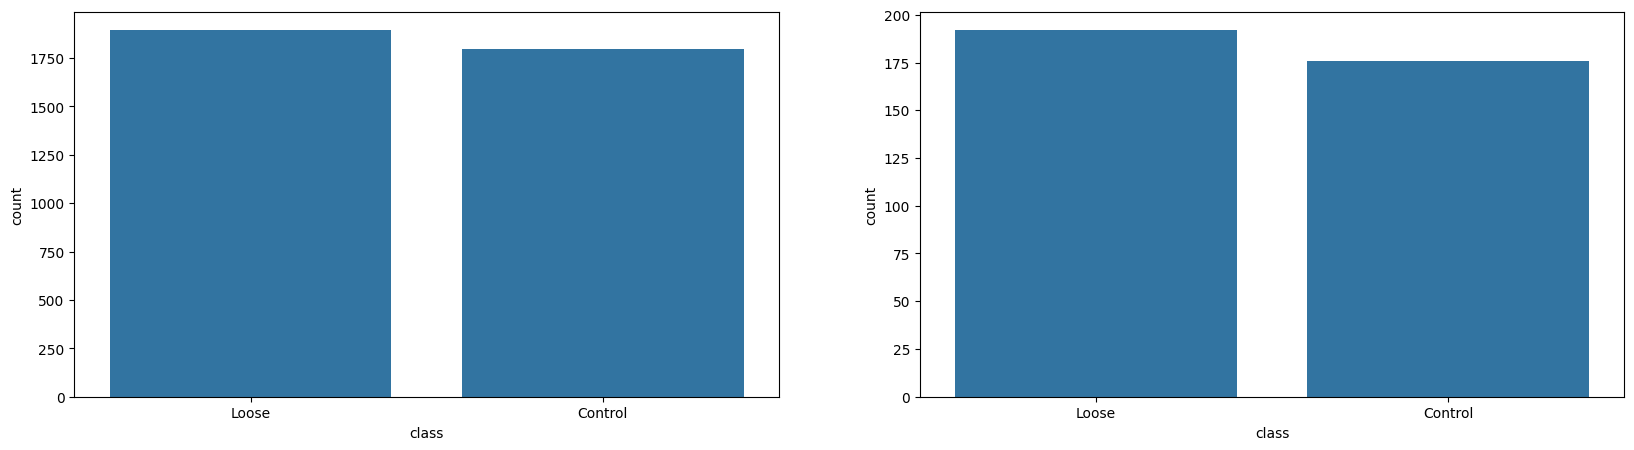

In [ ]:
root_path = '/content/archive (5)/Data/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/archive (5)/Data/train/' #one more seg_train folder within
seg_test_folders = '/content/archive (5)/Data/val/'
seg_pred_folders = '/content/archive (5)/Data/val/'
quantity_tr = {}
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

    epochs = range(len(acc))

    # Pass data as a dictionary to sns.lineplot
    sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs, y=val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    # Pass data as a dictionary to sns.lineplot
    sns.lineplot(x=epochs, y=loss, label='Training Loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 3691 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Control': 0, 'Loose': 1}
{0: 'Control', 1: 'Loose'}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            display = cv2.resize(display, (150, 150))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                display_for_prediction = display.astype('float32') / 255.0
                display_for_prediction = np.expand_dims(display_for_prediction, axis=0)
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

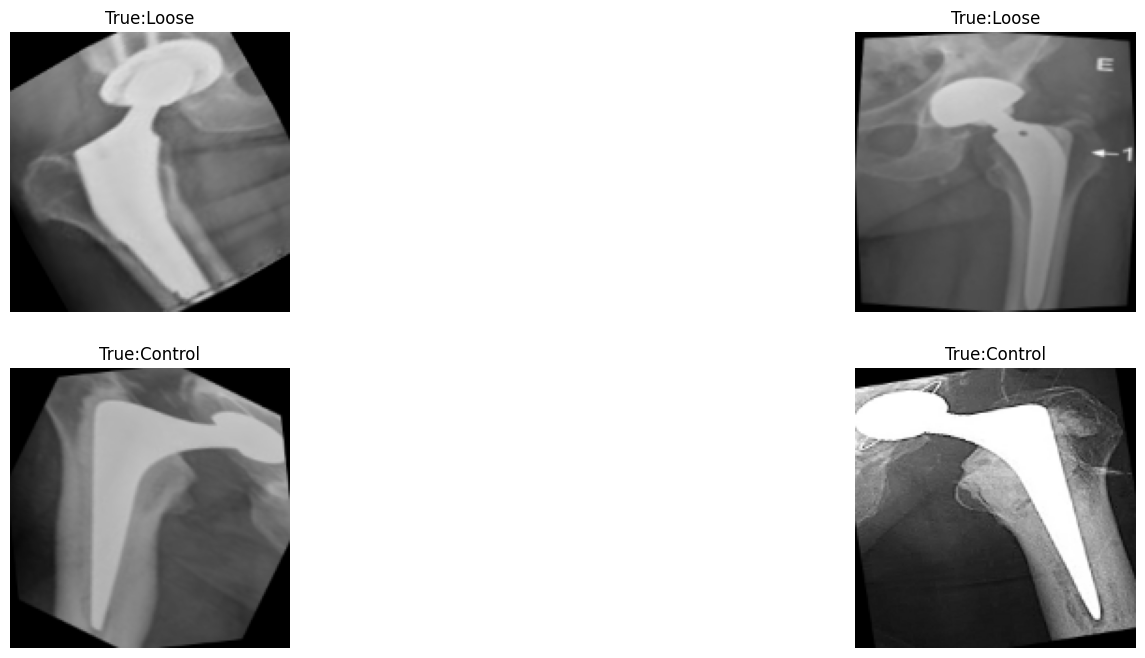

In [ ]:
show_few_images(2)

In [ ]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 1
vgg_epoch = 30
resnet_epoch = 50
inception_epoch = 30

In [ ]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(2,activation='softmax')) # Changed 6 to 2 since there are two classes

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Changed metrics from acc to accuracy

benchmark_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 144, 144, 128)       │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 67, 67, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,612,802 (32.86 MB)

 Trainable params: 8,612,802 (32.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5071 - loss: 1.0920
Epoch 1: val_accuracy improved from -inf to 0.52174, saving model to bench_mark_-model-01-0.52.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.5071 - loss: 1.0894 - val_accuracy: 0.5217 - val_loss: 0.6927 - learning_rate: 0.0010


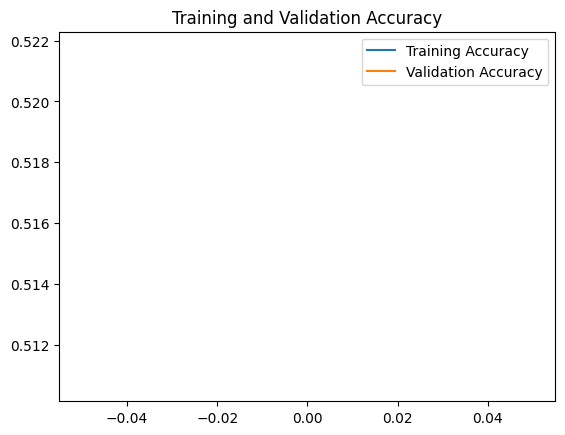

<Figure size 640x480 with 0 Axes>

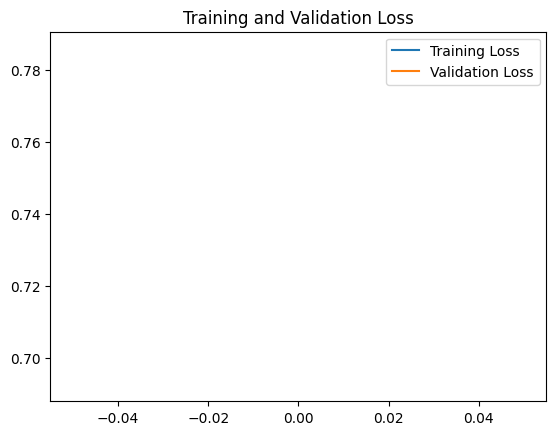

<Figure size 640x480 with 0 Axes>

In [ ]:
filepath = "bench_mark_-model-{epoch:02d}-{val_accuracy:.2f}.keras" # Changed the file extension to .keras
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #Changed from val_acc to val_accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model',isinception=True)

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - acc: 0.6043 - loss: 0.6365
Epoch 1: val_acc improved from -inf to 0.61413, saving model to vgg_16_-saved-model-01-acc-0.61.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - acc: 0.6051 - loss: 0.6359 - val_acc: 0.6141 - val_loss: 0.6145
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - acc: 0.8165 - loss: 0.4370
Epoch 2: val_acc improved from 0.61413 to 0.61957, saving model to vgg_16_-saved-model-02-acc-0.62.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - acc: 0.8166 - loss: 0.4368 - val_acc: 0.6196 - val_loss: 0.6517
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - acc: 0.8443 - loss: 0.3557
Epoch 3: val_acc improved from 0.61957 to 0.66304, saving model to vgg_16_-saved-model-03-acc-0.66.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 250ms/step - acc: 0.8444 - loss: 0.3555 - val_acc: 0.6630 - val_loss: 0.6073
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - acc: 0.8675 - loss: 0.3036
Epoch 4: val_acc improved 

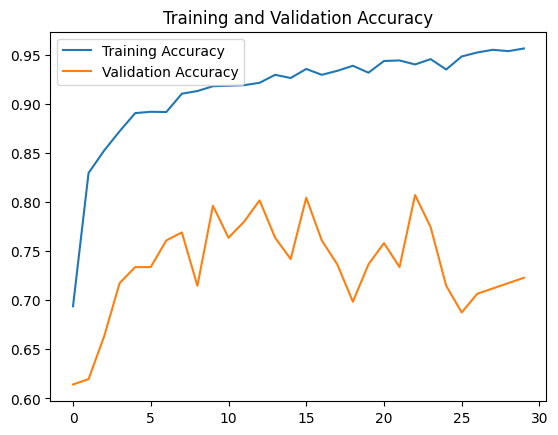

<Figure size 640x480 with 0 Axes>

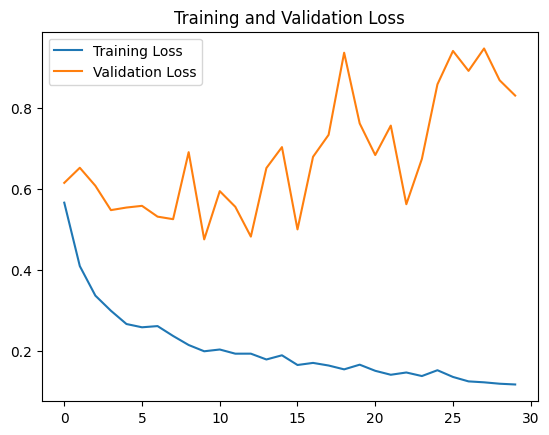

<Figure size 640x480 with 0 Axes>

In [ ]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(2, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.keras'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - acc: 0.7693 - loss: 1.1156
Epoch 1: val_acc improved from -inf to 0.47826, saving model to resnet50-saved-model-01-val_acc-0.48.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 92s 470ms/step - acc: 0.7702 - loss: 1.1096 - val_acc: 0.4783 - val_loss: 0.8930 - learning_rate: 0.0100
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - acc: 0.9813 - loss: 0.0542
Epoch 2: val_acc did not improve from 0.47826
116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 279ms/step - acc: 0.9813 - loss: 0.0542 - val_acc: 0.4783 - val_loss: 0.8247 - learning_rate: 0.0100
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - acc: 0.9937 - loss: 0.0156
Epoch 3: val_acc did not improve from 0.47826
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 275ms/step - acc: 0.9937 - loss: 0.0157 - val_acc: 0.4783 - val_loss: 1.4810 - learning_rate: 0.0100
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - acc: 0.9986 - loss: 0.0077
Epoch 4: val_acc

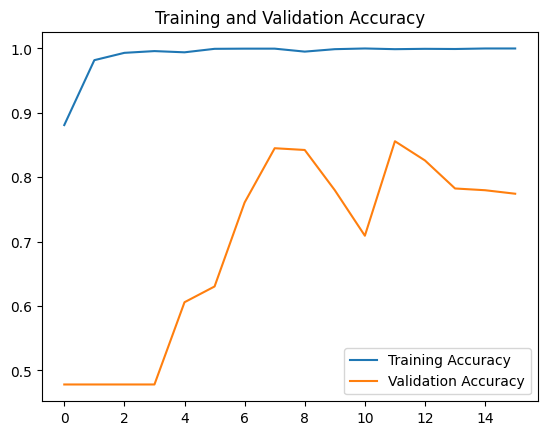

<Figure size 640x480 with 0 Axes>

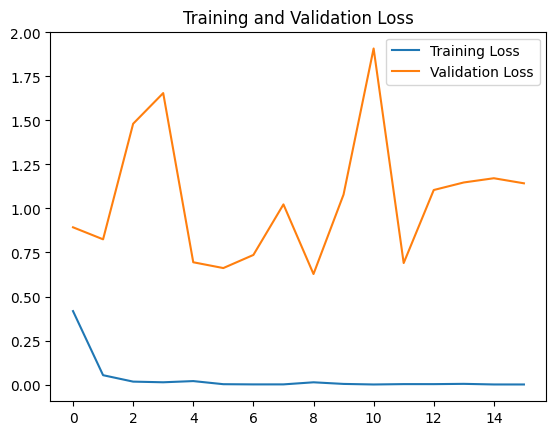

<Figure size 640x480 with 0 Axes>

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(learning_rate=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(2,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.keras'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 73s 423ms/step - accuracy: 0.5913 - loss: 0.7624 - val_accuracy: 0.5815 - val_loss: 0.7704
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step - accuracy: 0.7631 - loss: 0.5001 - val_accuracy: 0.6467 - val_loss: 0.7124
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - accuracy: 0.8299 - loss: 0.4105 - val_accuracy: 0.6576 - val_loss: 0.7155
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - accuracy: 0.8568 - loss: 0.3405 - val_accuracy: 0.7011 - val_loss: 0.6760
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.8982 - loss: 0.2658 - val_accuracy: 0.6739 - val_loss: 0.6985
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 255ms/step - accuracy: 0.9000 - loss: 0.2549 - val_accuracy: 0.7011 - val_loss: 0.7048
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.9264 - loss: 0.2028 - val_accuracy: 0.7255 - val_loss: 0.6710
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 30s 255ms/step - accuracy: 0.9398 - loss: 0.1763 - val_accuracy: 0.7174 - val_loss: 0.6799
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.9447 - loss: 0.1690 - val

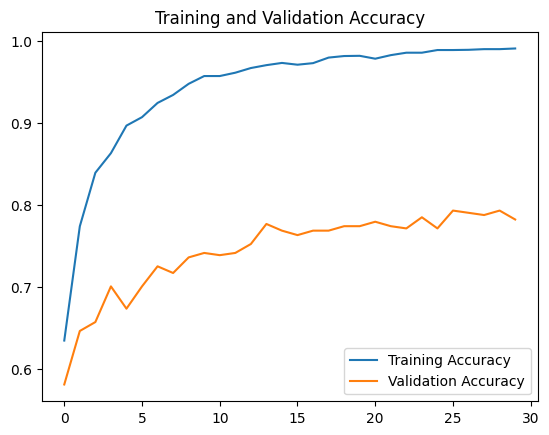

<Figure size 640x480 with 0 Axes>

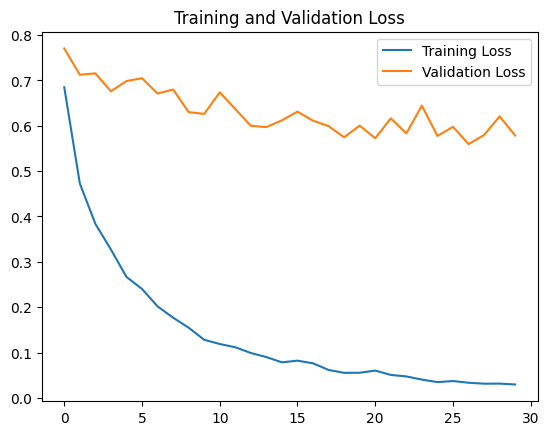

<Figure size 640x480 with 0 Axes>

In [ ]:

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(2, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.keras'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

In [ ]:
vgg_best_model = vgg16_final_model
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):

    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_test_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)

        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)

        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])
        combined_model_pred.append(image_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))


Model Accuracy 0.8152173913043478
              precision    recall  f1-score   support

     Control       0.73      0.98      0.83       176
       Loose       0.97      0.67      0.79       192

    accuracy                           0.82       368
   macro avg       0.85      0.82      0.81       368
weighted avg       0.85      0.82      0.81       368



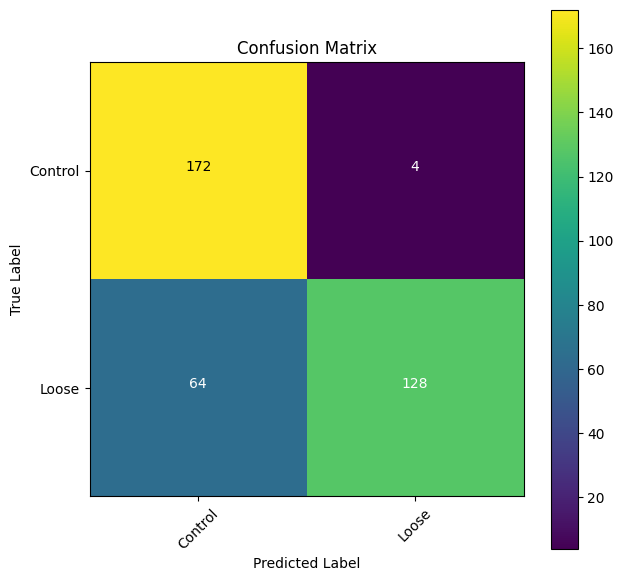

In [ ]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.7690217391304348
              precision    recall  f1-score   support

     Control       0.68      0.98      0.80       176
       Loose       0.97      0.58      0.72       192

    accuracy                           0.77       368
   macro avg       0.82      0.78      0.76       368
weighted avg       0.83      0.77      0.76       368



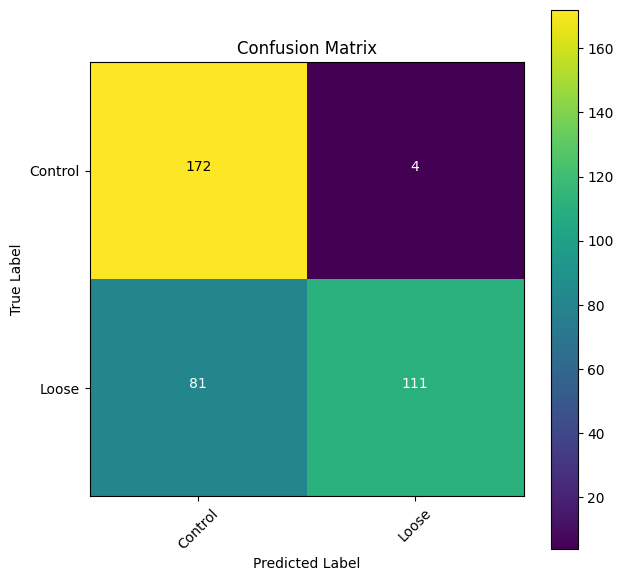

In [ ]:
# VGG model classification report
clf_report(true_value, vgg_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


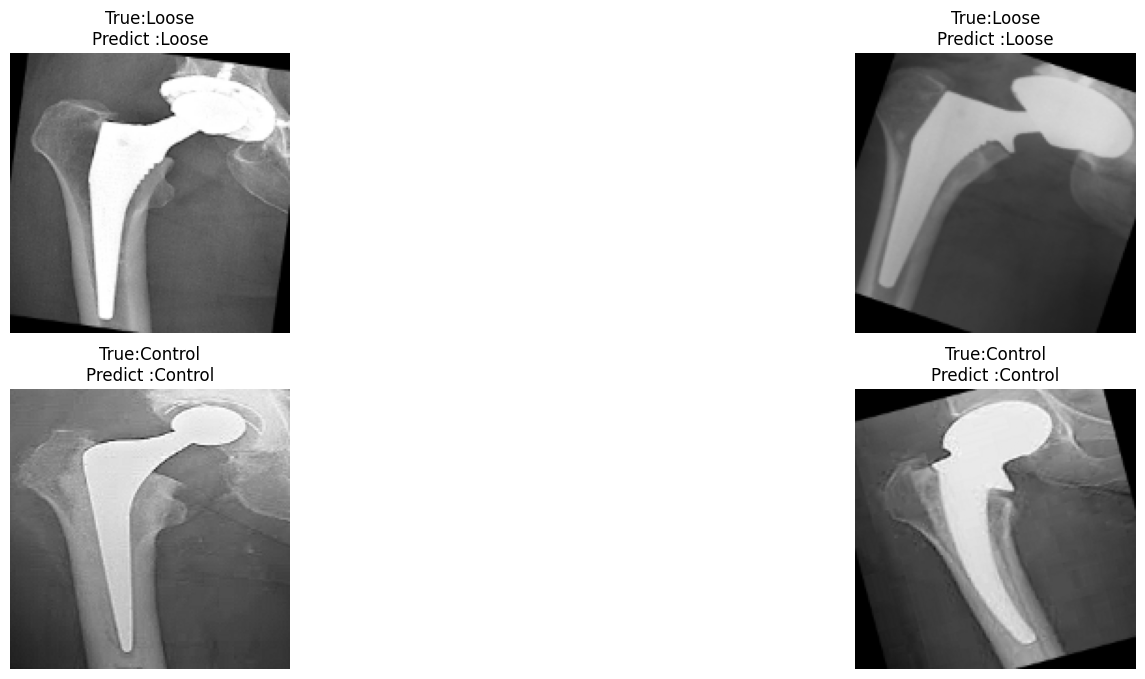

In [ ]:
show_few_images(2,combined_model_pred)

In [ ]:
'''# Save the model architecture to JSON file
model_json = InceptionV3_x_final_model.to_json()
with open('my_model.json', 'w') as json_file:
    json_file.write(model_json)

SyntaxError: incomplete input (<ipython-input-24-f2eadae2fdb8>, line 1)

In [ ]:
from sklearn.metrics import roc_curve, auc

    # ... (Your existing code to get predictions and true values)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_value, vgg_pred) # Replace vgg_pred with desired model predictions
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import tensorflow

from tensorflow.keras.preprocessing import image

# Load the model from a .keras file instead of a .json file

classes=['Control','Loose']
# inception_pred = [] # Removing the initialization here

def predict_image(image_path):
    inception_pred = [] # Initializing inception_pred inside the function
    img = cv2.resize(cv2.imread(image_path),(150,150))
    img_normalized = img/255

    plt.imshow(img)
    plt.show()
    # Use the resnet_best_model to make the prediction instead of resnet_50_image_prediction
    inception_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
    inception_pred.append(inception_image_prediction) # Append the prediction to inception_pred
    # Access the prediction directly using inception_image_prediction
    print("Actual: "+(image_path.split("/")[-2]).split("/")[0])
    print("Predicted: "+classes[inception_image_prediction]) # Print the predicted class label

In [ ]:
predict_image("/content/archive (5)/Data/val/Control/control (3)-rotated3-rotated1.png") #Example

In [ ]:
predict_image("/content/archive (5)/Data/train/Loose/loose (100)-sharpened-rotated1.png") #Example

In [ ]:
predict_image("/content/archive (5)/Data/val/Control/control (1)-sharpened1-rotated2.png") #Example

In [ ]:
predict_image("/content/archive (5)/Data/val/Loose/loose (13)-sharpened1-rotated1.png") #Example